In [1]:
import numpy as np
import ROOT
import matplotlib.pyplot as plt
from matplotlib import cycler, patches
import pandas as pd

Welcome to JupyROOT 6.24/02


In [2]:
import sys

sys.path.insert(1, '../..')
from pmt_he_study.format_plot import *
from functions.other_functions import *
from src.PMT_Classes import *
from array import array
from scipy.optimize import curve_fit

In [3]:
IPython_default = plt.rcParams.copy()
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

figsize = (4.5, 3)

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.family"] = "serif"

marker_size = 3
line_width = 0.5

colors = cycler('color', ['#EE6666', '#3388BB', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB', '#653700', '#F97306'])
plt.rc('axes', facecolor='white', edgecolor='black',
       axisbelow=True, grid=True, prop_cycle=colors)



In [4]:
def do_bi(hist, mean):

    lower = mean-10
    higher = mean+45

    fit = ROOT.TF1("fit",
                "[0]*"
                "(7.08*TMath::Gaus(x,[1],[2]) "
                " + 1.84*TMath::Gaus(x,[1]*(1 + 72.144/975.651),[2]*1.036) "
                " + 0.44*TMath::Gaus(x,[1]*(1 + 84.154/975.651),[2]*1.042)) ",
                lower, higher)

    fit.SetParNames("A", "mu", "sigma")

    fit.SetParLimits(0, 0, 400)
    fit.SetParLimits(1, lower, higher)
    fit.SetParLimits(2, 0.8, 100)
    fit.SetParameters(319, (higher+lower)/2, 1.09)

    hist.Fit("fit", "0Q", "", lower, higher)

    mu = fit.GetParameter(1)
    mu_err = fit.GetParError(1)
    sig = fit.GetParameter(2)
    sig_err = fit.GetParError(2)
    A = fit.GetParameter(0)
    A_err = fit.GetParError(0)
    chi = fit.GetChisquare()/fit.GetNDF()
    del fit
    return [[mu, mu_err], [sig, sig_err], [A, A_err], chi]

def do_bi_1000(hist, mean):

    lower = mean-1
    higher = mean+6

    fit = ROOT.TF1("fit",
                "[0]*"
                "(7.08*TMath::Gaus(x,[1],[2]) "
                " + 1.84*TMath::Gaus(x,[1]*(1 + 72.144/975.651),[2]*1.036) "
                " + 0.44*TMath::Gaus(x,[1]*(1 + 84.154/975.651),[2]*1.042)) ",
                lower, higher)

    fit.SetParNames("A", "mu", "sigma")

    fit.SetParLimits(0, 0, 400)
    fit.SetParLimits(1, lower, higher)
    fit.SetParLimits(2, 0.8, 10)
    fit.SetParameters(319, (higher+lower)/2, 1.09)

    hist.Fit("fit", "0Q", "", lower, higher)

    mu = fit.GetParameter(1)
    mu_err = fit.GetParError(1)
    sig = fit.GetParameter(2)
    sig_err = fit.GetParError(2)
    A = fit.GetParameter(0)
    A_err = fit.GetParError(0)
    chi = fit.GetChisquare()/fit.GetNDF()
    del fit
    return [[mu, mu_err], [sig, sig_err], [A, A_err], chi]

def get_mean(hist):
    max_bin = 0
    max_val = 0
    for i_bin in range(50, hist.GetNbinsX() + 1):
        if hist.GetBinContent(i_bin) > max_val:
            max_val = hist.GetBinContent(i_bin)
            max_bin = hist.GetBinLowEdge(i_bin)
    return max_bin
        

In [5]:
topology = [2, 1]
pmt_array = PMT_Array(topology, "summary")
pmt_array.set_pmt_id("GAO612", 1)
pmt_array.set_pmt_id("GAO607", 0)
    
filenames_txt = "/Users/williamquinn/Desktop/data/1400V/filenames.txt"
try:
    print(">>> Reading data from file: {}".format(filenames_txt))
    date_file = open(filenames_txt, 'r')
except FileNotFoundError as fnf_error:
    print(fnf_error)
    raise Exception("Error opening data file {}".format(filenames_txt))

filenames = np.loadtxt(filenames_txt, delimiter=',', dtype={
        'names': ['filename'],
        'formats': ['S100']}, unpack=True)

dates = [[], []]
nums = [[], []]
he_nums = [[], []]
nums_err = [[], []]
he_nums_err = [[], []]
av_charges = [[], []]
av_charges_err = [[], []]
mev_charge = [[], []]
mev_charge_err = [[], []]
chi2s = [[], []]

for i_file in range(filenames.size):
    filename = filenames[i_file][0].decode("utf-8")
    date = filename.split("_")[0]
    voltage = int(filename.split("_")[1].split("A")[1])

    file = ROOT.TFile("/Users/williamquinn/Desktop/data/1400V/" + filename, "READ")
    file.cd()

    for i_om in range(2):
        num_hist = file.Get(date + "_" + pmt_array.get_pmt_object_number(i_om).get_pmt_id() +
                                      "_apulse_num_" + str(voltage) + "V")
        he_num_hist = file.Get(date + "_" + pmt_array.get_pmt_object_number(i_om).get_pmt_id() +
                                      "_he_apulse_num_" + str(voltage) + "V")
        charge_hist = file.Get(date + "_" + pmt_array.get_pmt_object_number(i_om).get_pmt_id() +
                              "_charge_spectrum_" + str(voltage) + "V")
        try:
            num_hist.GetEntries()
            he_num_hist.GetEntries()
            charge_hist.GetEntries()
        except:
            continue
        mean = get_mean(charge_hist)
        charge_pars = do_bi(charge_hist, mean)

        dates[i_om].append(int(date))

        nums[i_om].append(num_hist.GetMean())
        he_nums[i_om].append(he_num_hist.GetMean())

        nums_err[i_om].append(num_hist.GetMeanError())
        he_nums_err[i_om].append(he_num_hist.GetMeanError())
        
        av_charges[i_om].append(charge_hist.GetMean())
        av_charges_err[i_om].append(np.sqrt(charge_hist.GetMean()))
        
        mev_charge[i_om].append(charge_pars[0][0])
        mev_charge_err[i_om].append(charge_pars[0][1])
        
        chi2s[i_om].append(charge_pars[-1])

        del num_hist
        del he_num_hist
        del charge_hist

#plot_aan(dates, nums, nums_err, "")
#plot_aan(dates, he_nums, he_nums_err, "he")
print(">>> Finished")

>>> Reading data from file: /Users/williamquinn/Desktop/data/1400V/filenames.txt
>>> Finished


In [6]:
G = 1700000
e = 1.603e-19

date_0 = process_date(dates[0])
date_1 = process_date(dates[1])

Text(0, 0.5, 'Average Pulse Charge /pC')

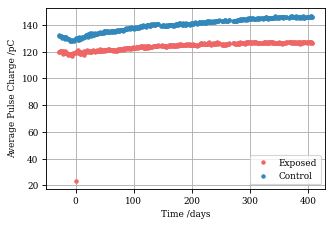

In [7]:
# p_i = model.func(x, pars) 
fig1 = plt.figure(num=None, figsize=(figsize), dpi=80, facecolor='w', edgecolor='k')
plt.plot(date_0, av_charges[0], '.', label='Exposed', zorder=10)
plt.plot(date_1, av_charges[1], '.', label='Control', zorder=10)
plt.legend(loc='best')
plt.xlabel("Time /days")
plt.ylabel("Average Pulse Charge /pC")

In [48]:
x0, y0, x1, y1 = [], [], [], []
for i in range(len(date_0)):
    if av_charges[0][i] > 100:
        x0.append(date_0[i])
        y0.append(av_charges[0][i])
for i in range(len(dates[1])):
    if av_charges[1][i] > 100:
        x1.append(date_1[i])
        y1.append(av_charges[1][i])

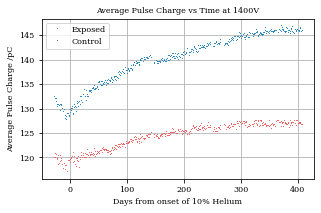

In [49]:
plt.figure(figsize=figsize)
plt.plot(x0, y0, ",", label='Exposed')
plt.plot(x1, y1, ",", label='Control')
plt.legend(loc='best')
plt.xlabel("Days from onset of 10% Helium")
plt.ylabel("Average Pulse Charge /pC")
plt.title("Average Pulse Charge vs Time at 1400V")
plt.tight_layout()
plt.savefig("/Users/williamquinn/Desktop/PMT_Project/av_pulse_charge_vs_time_1400V.pdf")

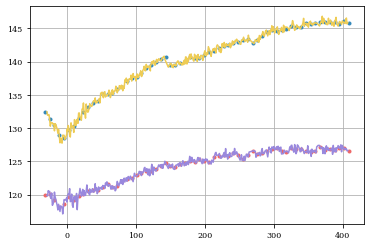

In [9]:
av_0 = [0 for i in range(-5, 59)]
av_y0 = [0 for i in range(-5, 59)]
w0 = [i for i in range(-5, 59)]

av_1 = [0 for i in range(-5, 59)]
av_y1 = [0 for i in range(-5, 59)]
w1 = [i for i in range(-5, 59)]

for i in range(len(x0)):
    x = x0[i]
    
    week = x // 7
    pos = week + 5
    # print(week)
    
    av_y0[pos] += y0[i]
    av_0[pos] += 1
    
for i in range(len(x1)):
    x = x1[i]
    
    week = x // 7
    pos = week + 5
    # print(week)
    
    av_y1[pos] += y1[i]
    av_1[pos] += 1

w0_1400 = []    
av_tot_charge_0 = []   
for j in range(len(av_y0)):
    if av_0[j] > 0:
        w0_1400.append(w0[j])
        av_tot_charge_0.append(av_y0[j]/av_0[j])
plt.plot(np.array(w0_1400)*7 + 3, av_tot_charge_0, ".")

w1_1400 = []
av_tot_charge_1 = []   
for j in range(len(av_y1)):
    if av_1[j] > 0:
        w1_1400.append(w0[j])
        av_tot_charge_1.append(av_y1[j]/av_1[j])
plt.plot(np.array(w0_1400)*7 + 3, av_tot_charge_1, ".")
plt.plot(x0, y0)
plt.plot(x1, y1)

In [10]:
new_w0 = [i for i in range(-5, 59)]
w0_1400_clone = w0_1400.copy()
av_tot_charge_0_clone = av_tot_charge_0.copy()

for i in range(len(new_w0)):
    w = w0_1400_clone[i]
    if w != new_w0[i]:
        w0_1400_clone.insert(i, new_w0[i])
        av_tot_charge_0_clone.insert(i, -10)
        
w1_1400_clone = w1_1400.copy()
av_tot_charge_1_clone = av_tot_charge_1.copy()

for i in range(len(new_w0)):
    w = w1_1400_clone[i]
    if w != new_w0[i]:
        w1_1400_clone.insert(i, new_w0[i])
        av_tot_charge_1_clone.insert(i, -10)

<Figure size 360x240 with 0 Axes>

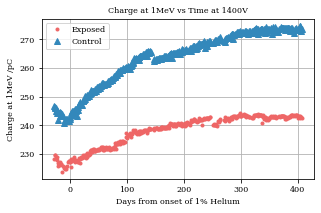

In [81]:
fig1 = plt.figure(num=None, figsize=(figsize), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(date_0[mid + 1:], model.func(x, pars), 'k-', label='Model', zorder=10)
x0, y0, x1, y1 = [], [], [], []
for i in range(len(dates[0])):
    if chi2s[0][i] < 10 and mev_charge[0][i] > 200:
        x0.append(process_date([dates[0][i]])[0])
        y0.append(mev_charge[0][i])
for i in range(len(dates[1])):
    if chi2s[1][i] < 10 and mev_charge[1][i] > 200:
        x1.append(process_date([dates[1][i]])[0])
        y1.append(mev_charge[1][i])
        
x0 = np.array(x0)
x1 = np.array(x1)

plt.figure(figsize=figsize, facecolor='white')

plt.plot(x0, y0, '.', label='Exposed')
plt.plot(x1, y1, '^', label='Control')

plt.legend(loc='best')
plt.xlabel("Days from onset of 1% Helium")
plt.ylabel("Charge at 1MeV /pC")
plt.title("Charge at 1MeV vs Time at 1400V")
plt.tight_layout()
plt.savefig("/Users/williamquinn/Desktop/PMT_Project/MeV_charge_vs_time_1400V.pdf")

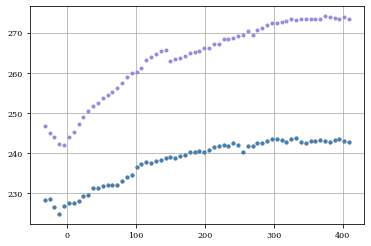

In [12]:
av_0 = [0 for i in range(-5, 59)]
av_y0 = [0 for i in range(-5, 59)]
w0 = [i for i in range(-5, 59)]

av_1 = [0 for i in range(-5, 59)]
av_y1 = [0 for i in range(-5, 59)]
w1 = [i for i in range(-5, 59)]

for i in range(len(x0)):
    x = x0[i]
    
    week = x // 7
    pos = week + 5
    # print(week)
    
    av_y0[pos] += y0[i]
    av_0[pos] += 1
    
for i in range(len(x1)):
    x = x1[i]
    
    week = x // 7
    pos = week + 5
    # print(week)
    
    av_y1[pos] += y1[i]
    av_1[pos] += 1
    
w0_1400 = []
av_mev_charge_0 = []   
for j in range(len(av_y0)):
    if av_0[j] > 0:
        w0_1400.append(w0[j])
        av_mev_charge_0.append(av_y0[j]/av_0[j])
plt.plot(np.array(w0_1400)*7 + 3, av_mev_charge_0, ".")

w1_1400 = []
av_mev_charge_1 = []   
for j in range(len(av_y1)):
    if av_1[j] > 0:
        w1_1400.append(w0[j])
        av_mev_charge_1.append(av_y1[j]/av_1[j])
        
plt.plot(np.array(w0_1400)*7 + 3, av_mev_charge_0, ".")
plt.plot(np.array(w1_1400)*7 + 3, av_mev_charge_1, ".")


In [13]:
dates_1000 = [[], []]
topology = [2, 1]
pmt_array = PMT_Array(topology, "summary")
pmt_array.set_pmt_id("GAO612", 1)
pmt_array.set_pmt_id("GAO607", 0)
    
mev_1000_charge = [[], []]
mev_1000_charge_err = [[], []]
gains = [[], []]
chi2s_1000 = [[], []]

filenames_txt = "/Users/williamquinn/Desktop/data/1000V/filenames.txt"
try:
    print(">>> Reading data from file: {}".format(filenames_txt))
    date_file = open(filenames_txt, 'r')
except FileNotFoundError as fnf_error:
    print(fnf_error)
    raise Exception("Error opening data file {}".format(filenames_txt))

filenames = np.loadtxt(filenames_txt, delimiter=',', dtype={
        'names': ['filename'],
        'formats': ['S100']}, unpack=True)

for i_file in range(filenames.size):
    filename = filenames[i_file][0].decode("utf-8")
    date = filename.split("_")[0]
    voltage = int(filename.split("_")[1].split("A")[1])

    file = ROOT.TFile("/Users/williamquinn/Desktop/data/1000V/" + filename, "READ")
    file.cd()

    for i_om in range(2):
        charge_hist = file.Get(date + "_" + pmt_array.get_pmt_object_number(i_om).get_pmt_id() +
                               "_charge_spectrum_" + str(voltage) + "V")
        
        try:
            charge_hist.GetEntries()
        except:
            continue
        mean = get_mean(charge_hist)
        try:
            charge_pars = do_bi_1000(charge_hist, mean)
        except:
            print("no")
            continue
        
        dates_1000[i_om].append(int(date))
        
        mev_1000_charge[i_om].append(charge_pars[0][0])
        mev_1000_charge_err[i_om].append(charge_pars[0][1])
        
        R = charge_pars[1][0]/charge_pars[0][0]
        gains[i_om].append(R**2*charge_pars[0][0]*1e-12/e)
        
        chi2s_1000[i_om].append(charge_pars[-1])

        del charge_hist
print(">>> Finished")

>>> Reading data from file: /Users/williamquinn/Desktop/data/1000V/filenames.txt
no
>>> Finished


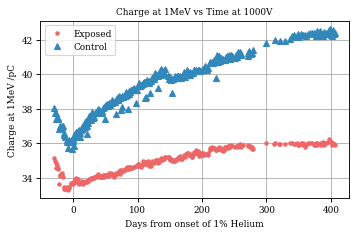

In [82]:
fig1 = plt.figure(num=None, figsize=(figsize), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(date_0[mid + 1:], model.func(x, pars), 'k-', label='Model', zorder=10)
x0, y0, x1, y1, g0, g1 = [], [], [], [], [], []
for i in range(len(dates_1000[0])):
    if chi2s_1000[0][i] < 10 and mev_1000_charge[0][i] > 20:
        x0.append(process_date([dates_1000[0][i]])[0])
        y0.append(mev_1000_charge[0][i])
        g0.append(gains[0][i])
for i in range(len(dates_1000[1])):
    if chi2s_1000[1][i] < 10 and mev_1000_charge[1][i] > 20:
        x1.append(process_date([dates_1000[1][i]])[0])
        y1.append(mev_1000_charge[1][i])
        g1.append(gains[1][i])

x0 = np.array(x0)
x1 = np.array(x1)

plt.plot(x0, y0, '.', label='Exposed')
plt.plot(x1, y1, '^', label='Control')

plt.legend(loc='best')
plt.xlabel("Days from onset of 1% Helium")
plt.ylabel("Charge at 1MeV /pC")
plt.title("Charge at 1MeV vs Time at 1000V")
plt.tight_layout()
plt.savefig("/Users/williamquinn/Desktop/PMT_Project/MeV_charge_vs_time_1000V.pdf")

Text(0, 0.5, 'Resolution')

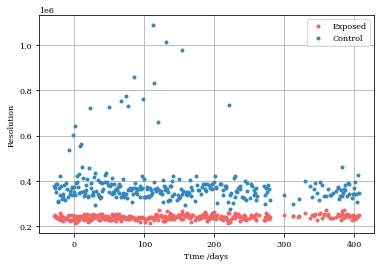

In [15]:
plt.plot(x0, g0, '.', label='Exposed', zorder=10)
plt.plot(x1, g1, '.', label='Control', zorder=10)

plt.legend(loc='best')
plt.xlabel("Time /days")
plt.ylabel("Resolution")

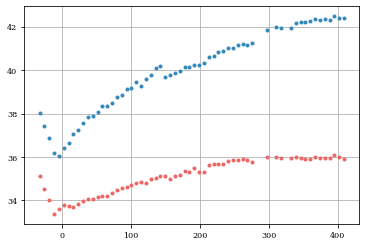

In [16]:
av_0 = [0 for i in range(-5, 59)]
av_y0 = [0 for i in range(-5, 59)]
av_g0 = [0 for i in range(-5, 59)]
w0 = [i for i in range(-5, 59)]

av_1 = [0 for i in range(-5, 59)]
av_y1 = [0 for i in range(-5, 59)]
av_g1 = [0 for i in range(-5, 59)]
w1 = [i for i in range(-5, 59)]

for i in range(len(x0)):
    x = x0[i]
    
    week = x // 7
    pos = week + 5
    
    av_y0[pos] += y0[i]
    av_g0[pos] += g0[i]
    av_0[pos] += 1
    
for i in range(len(x1)):
    x = x1[i]
    
    week = x // 7
    pos = week + 5
    
    av_y1[pos] += y1[i]
    av_g1[pos] += g1[i]
    av_1[pos] += 1
    
w0_1000 = []
av_mev_1000_charge_0 = []   
av_gain_0 = []
for j in range(len(av_y0)):
    if av_0[j] > 0:
        w0_1000.append(w0[j])
        av_mev_1000_charge_0.append(av_y0[j]/av_0[j])
        av_gain_0.append(av_g0[j]/av_0[j])
        
w1_1000 = []
av_mev_1000_charge_1 = []
av_gain_1 = []
for j in range(len(av_y1)):
    if av_1[j] > 0:
        w1_1000.append(w0[j])
        av_mev_1000_charge_1.append(av_y1[j]/av_1[j])
        av_gain_1.append(av_g1[j]/av_1[j])
        
plt.plot(np.array(w0_1000)*7 + 3, av_mev_1000_charge_0, ".")
plt.plot(np.array(w1_1000)*7 + 3, av_mev_1000_charge_1, ".")
#plt.plot(x0, y0, ".")

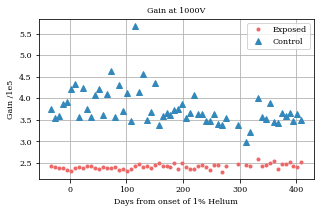

In [80]:
plt.figure(figsize=figsize, facecolor='white')
plt.plot(np.array(w0_1000)*7 + 3, np.array(av_gain_0)/1e5, ".", label='Exposed')
plt.plot(np.array(w1_1000)*7 + 3, np.array(av_gain_1)/1e5, "^", label='Control')
plt.legend(loc='best')
plt.xlabel("Days from onset of 1% Helium")
plt.ylabel("Gain /1e5")
plt.title("Gain at 1000V")
plt.tight_layout()
plt.savefig("/Users/williamquinn/Desktop/PMT_Project/gain_1000V.pdf")

In [18]:
new_w0 = [i for i in range(-5, 59)]
w0_1000_clone = w0_1000.copy()
av_mev_1000_charge_0_clone = av_mev_1000_charge_0.copy()
av_gain_0_clone = av_gain_0.copy()

for i in range(len(new_w0)):
    w = w0_1000_clone[i]
    if w != new_w0[i]:
        w0_1000_clone.insert(i, new_w0[i])
        av_mev_1000_charge_0_clone.insert(i, -10)
        av_gain_0_clone.insert(i, 10)
        
w1_1000_clone = w1_1000.copy()
av_mev_1000_charge_1_clone = av_mev_1000_charge_1.copy()
av_gain_1_clone = av_gain_1.copy()

for i in range(len(new_w0)):
    w = w1_1000_clone[i]
    if w != new_w0[i]:
        w1_1000_clone.insert(i, new_w0[i])
        av_mev_1000_charge_1_clone.insert(i, -10)
        av_gain_1_clone.insert(i, 10)
        
w0_1400_clone = w0_1400.copy()
av_mev_charge_0_clone = av_mev_charge_0.copy()

for i in range(len(new_w0)):
    w = w0_1400_clone[i]
    if w != new_w0[i]:
        w0_1400_clone.insert(i, new_w0[i])
        av_mev_charge_0_clone.insert(i, -10)
        
w1_1400_clone = w1_1400.copy()
av_mev_charge_1_clone = av_mev_charge_1.copy()

for i in range(len(new_w0)):
    w = w1_1400_clone[i]
    if w != new_w0[i]:
        w1_1400_clone.insert(i, new_w0[i])
        av_mev_charge_1_clone.insert(i, -10)


In [19]:
'''file = open("/Users/williamquinn/Desktop/test.csv", "w")
file.write('week, Ch0 MeV Charge at 1000V, Ch1 MeV Charge at 1000V, Ch0 gain at 1000V, Ch1 gain at 1000V, Ch0 MeV Charge at 1400V, Ch1 MeV Charge at 1400V, Ch0 Average Charge at 1400V, Ch0 Average Charge at 1400V\n')
for i in range(len(new_w0)):
    file.write("{},{},{},{},{},{},{},{},{}\n".format(new_w0[i],
                                                     av_mev_1000_charge_0_clone[i],
                                                     av_mev_1000_charge_1_clone[i],
                                                     av_gain_0_clone[i],
                                                     av_gain_1_clone[i],
                                                     av_mev_charge_0_clone[i],
                                                     av_mev_charge_1_clone[i],
                                                     av_tot_charge_0_clone[i],
                                                     av_tot_charge_1_clone[i]))
file.close()'''

'file = open("/Users/williamquinn/Desktop/test.csv", "w")\nfile.write(\'week, Ch0 MeV Charge at 1000V, Ch1 MeV Charge at 1000V, Ch0 gain at 1000V, Ch1 gain at 1000V, Ch0 MeV Charge at 1400V, Ch1 MeV Charge at 1400V, Ch0 Average Charge at 1400V, Ch0 Average Charge at 1400V\n\')\nfor i in range(len(new_w0)):\n    file.write("{},{},{},{},{},{},{},{},{}\n".format(new_w0[i],\n                                                     av_mev_1000_charge_0_clone[i],\n                                                     av_mev_1000_charge_1_clone[i],\n                                                     av_gain_0_clone[i],\n                                                     av_gain_1_clone[i],\n                                                     av_mev_charge_0_clone[i],\n                                                     av_mev_charge_1_clone[i],\n                                                     av_tot_charge_0_clone[i],\n                                                     av_tot_charge_1

In [20]:
file = file = open("/Users/williamquinn/Desktop/test.csv", "r")
fl = file.readlines()
w = []
gain_ch0 = []
gain_ch1 = []
av_charge_ch0 = []
av_charge_ch1 = []
for index, line in enumerate(fl):
    if index == 0:
        continue
    line_list = line.split(",")
    w.append(int(line_list[0]))
    gain_ch0.append(float(line_list[5])/float(line_list[1]) * float(line_list[3]))
    gain_ch1.append(float(line_list[6])/float(line_list[2]) * float(line_list[4]))
    av_charge_ch0.append(float(line_list[7]))
    av_charge_ch1.append(float(line_list[8]))
    
w = np.array(w)
gain_ch0 = np.array(gain_ch0)
gain_ch1 = np.array(gain_ch1)
av_charge_ch0 = np.array(av_charge_ch0)
av_charge_ch1 = np.array(av_charge_ch1)

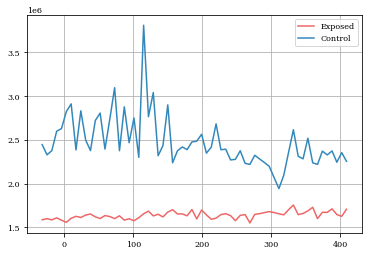

In [21]:
plt.plot(w*7 + 3, gain_ch0, label='Exposed')
plt.plot(w*7 + 3, gain_ch1, label='Control')
plt.legend(loc='best')

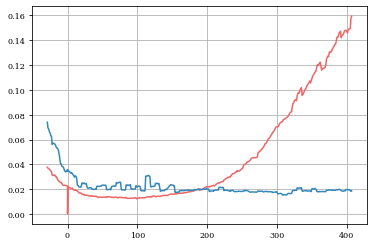

In [71]:
def pp(x, G, C, aan):
    y = []
    for i in range(len(x)):
        week = x[i] // 7
        pos = week + 5
        G_i = G[pos]
        C_i = C[pos]
        y.append(18.5*G_i*e*aan[i]*1e12/C_i )
    return y
def pp_k(x, G, C, P1):
    y = []
    for i in range(len(x)):
        week = x[i] // 7
        pos = week + 5
        G_i = G[pos]
        C_i = C[pos]
        y.append(18.5*G_i*e*P1*1e12/C_i )
    return y
        
plt.plot(date_0, pp(date_0, gain_ch0, av_charge_ch0, nums[0]))
plt.plot(date_1, pp(date_1, gain_ch1, av_charge_ch1, nums[1]))

In [130]:
def root_fit(x, y, yerr, model):
    # guess = array('d', [1.52157116e-11, 6.84547311e-02, 1.13069872e+07])
    guess = array('d', [(y[-1] - y[-50])/((x[-1] - x[-50])*3600*24) /10000, y[0], 300*3600*24])
    names = ["p0", "p1", "L"]
    graph = ROOT.TGraphErrors(len(y), array('d', [i for i in x]), array('d', [i for i in y]),
                              array('d', [1 for i in range(len(x))]), array('d', [i for i in yerr]))

    fit = ROOT.TF1("func", model, float(x[0]), float(x[-1]), len(guess))
    for i in range(len(guess)):
        fit.SetParameter(i, guess[i])
        fit.SetParName(i, names[i])
        fit.SetParLimits(i, guess[i] - abs(guess[i])/2, guess[i] + abs(guess[i])/2)

    graph.Fit("func", "0Q")
    pars = []
    errs = []
    chi = fit.GetChisquare() / fit.GetNDF()

    for i in range(len(guess)):
        pars.append(fit.GetParameter(i))
        errs.append(fit.GetParError(i))
    return pars, errs, chi

class Model:
    def __call__(self, x, pars):
        p = 101325 / 10
        p0 = pars[0]
        p1 = pars[1]
        L = pars[2]
        t = x[0] * 3600 * 24

        temp = 0
        for n in range(1, 50):
            temp += ((-1) ** n / n ** 2) * (1 - np.exp(-(n ** 2) * (np.pi ** 2) * t / (L * 6)))
        f2 = (12 / np.pi ** 2) * L * temp
        y = p0 * p * (t + f2) + p1
        return y

    def func(self, x, pars):
        p = 101325 / 10
        p0 = pars[0]
        p1 = pars[1]
        L = pars[2]
        t = x * 3600 * 24

        temp = 0
        for n in range(1, 50):
            temp += ((-1) ** n / n ** 2) * (1 - np.exp(-(n ** 2) * (np.pi ** 2) * t / (L * 6)))
        f2 = (12 / np.pi ** 2) * L * temp
        y = p0 * p * (t + f2) + p1
        return y
    
class Model_var:
    def __call__(self, x, pars, p):
        p0 = pars[0]
        p1 = pars[1]
        L = pars[2]
        t = x[0] * 3600 * 24

        temp = 0
        for n in range(1, 50):
            temp += ((-1) ** n / n ** 2) * (1 - np.exp(-(n ** 2) * (np.pi ** 2) * t / (L * 6)))
        f2 = (12 / np.pi ** 2) * L * temp
        y = p0 * p * (t + f2) + p1
        return y

    def func(self, x, pars, p):
        p0 = pars[0]
        p1 = pars[1]
        L = pars[2]
        t = x * 3600 * 24

        temp = 0
        for n in range(1, 50):
            temp += ((-1) ** n / n ** 2) * (1 - np.exp(-(n ** 2) * (np.pi ** 2) * t / (L * 6)))
        f2 = (12 / np.pi ** 2) * L * temp
        y = p0 * p * (t + f2) + p1
        return y
    
class Model_0:
    def __call__(self, x, pars):
        pe_0 = 101325 / 100
        pe_1 = 101325 / 10
        p0 = pars[0]
        p1 = pars[1]
        L = pars[2]

        t_0 = (x[0] + 98) * 3600 * 24
        t_1 = t_0 - (98 * 3600 * 24)
        temp_0 = 0
        temp_1 = 0
        for n in range(1, 50):
            temp_0 += ((-1) ** n / n ** 2) * (1 - np.exp(-(n ** 2) * (np.pi ** 2) * t_0 / (L * 6)))
            temp_1 += ((-1) ** n / n ** 2) * (1 - np.exp(-(n ** 2) * (np.pi ** 2) * t_1 / (L * 6)))
        f_0 = (12 / np.pi ** 2) * L * temp_0
        f_1 = (12 / np.pi ** 2) * L * temp_1

        y = p0 * (pe_0 * (t_0 + f_0) + pe_1 * (t_1 + f_1)) + p1
        return y

    def func(self, x, pars):
        pe_0 = 101325 / 100
        pe_1 = 101325 / 10
        p0 = pars[0]
        p1 = pars[1]
        L = pars[2]

        t_0 = (x + 98) * 3600 * 24
        t_1 = t_0 - (98 * 3600 * 24)
        temp_0 = 0
        temp_1 = 0
        for n in range(1, 50):
            temp_0 += ((-1) ** n / n ** 2) * (1 - np.exp(-(n ** 2) * (np.pi ** 2) * t_0 / (L * 6)))
            temp_1 += ((-1) ** n / n ** 2) * (1 - np.exp(-(n ** 2) * (np.pi ** 2) * t_1 / (L * 6)))
        f_0 = (12 / np.pi ** 2) * L * temp_0
        f_1 = (12 / np.pi ** 2) * L * temp_1

        y = p0 * (pe_0 * (t_0 + f_0) + pe_1 * (t_1 + f_1)) + p1
        return y

In [136]:
model = Model()

try:
    start = np.where(date_0 == 0)[0][0]
except:
    start = np.where(date_0 == 1)[0][0]
mid = np.where(date_0 == 98)[0][0]

pp0 = pp(date_0, gain_ch0, av_charge_ch0, nums[0])
pp1 = pp(date_1, gain_ch1, av_charge_ch1, nums[1])
pp0_err = np.array(pp0)*0.01
pp1_err = np.array(pp1)*0.01

x = np.array(date_0[mid + 1:]) - date_0[mid + 1:][0]
y = pp0[mid + 1:]
yerr = pp0_err[mid + 1:]
pars, errs, chi = root_fit(x, y, yerr, model)
x_model = np.array(date_0[mid + 1:])
y_model = model.func(x, pars)

x_0, y_0, y_err_0 = np.array(date_0[:start + 1]), np.array(pp0[:start + 1]), np.array(pp0_err[:start + 1])
x_1, y_1, y_err_1 = np.array(date_0[start + 1:mid + 1]), np.array(pp0[start + 1:mid + 1]), np.array(pp0_err[start + 1:mid + 1])
x_2, y_2, y_err_2 = np.array(date_0[mid + 1:]), np.array(pp0[mid + 1:]), np.array(pp0_err[mid + 1:])
x_3, y_3, y_err_3 = np.array(date_1), np.array(pp1), np.array(pp1_err)

k = pars[1]

/var/folders/z0/ktldz45s5hn1fwbvyy8qxzdh0000gn/T/ipykernel_79615/1659721082.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


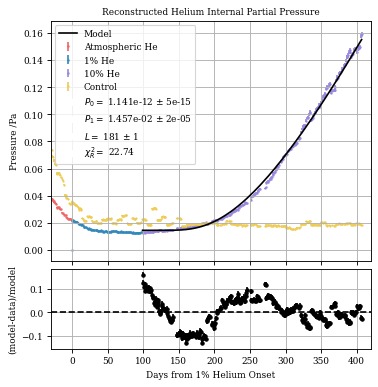

In [139]:
fig1 = plt.figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
frame1 = fig1.add_axes((.15, .32, .8, .6))
frame1.set_xticklabels([])
plt.errorbar(x_0, y_0, zorder=0, yerr=y_err_0, fmt="C0s", label="Atmospheric He", markersize=1)
plt.errorbar(x_1, y_1, zorder=0, yerr=y_err_1, fmt="C1s", label="1% He", markersize=1)
plt.errorbar(x_2, y_2, zorder=0, yerr=y_err_2, fmt="C2s", label="10% He", markersize=1)
plt.errorbar(x_3, y_3, zorder=0, yerr=y_err_3, fmt="C3o", label="Control", markersize=1)
plt.plot(x_model, y_model, 'k-', label='Model', zorder=10)
# plt.axvline(date_0[start], 0, 100, ls='--', color='k')
# plt.axvline(date_0[mid], 0, 100, ls='--', color='k')

handles, labels = plt.gca().get_legend_handles_labels()
patch = patches.Patch(color='white', label=r'$P_0 =$ {:.3e} ± {:.0e}'.format(pars[0], errs[0]))
patch_1 = patches.Patch(color='white', label=r'$P_1 =$ {:.3e} ± {:.0e}'.format(pars[1], errs[1]))
patch_2 = patches.Patch(color='white', label=r'$L =$ {:.0f} ± {:.0f}'.format(pars[2] / (3600 * 24), errs[2] / (3600 * 24)))
patch_3 = patches.Patch(color='white', label=r'$\chi^2_R =$ {:.2f}'.format(chi))
handles.extend([patch, patch_1, patch_2, patch_3])

plt.ylabel("Pressure /Pa")
plt.title("Reconstructed Helium Internal Partial Pressure")
plt.xlim(-30, 420)
plt.legend(handles=handles, loc='upper left')

frame2 = fig1.add_axes((.15, .1, .8, .2))
plt.xlabel("Days from 1% Helium Onset")
plt.axhline(0, ls='--', color='black')
plt.ylabel("(model-data)/model")
plt.xlim(-30, 420)
plt.errorbar(x_model, (y_model - y_2) / y_model, yerr=y_err_2/y, fmt="k.")
plt.tight_layout()

plt.savefig("/Users/williamquinn/Desktop/PMT_Project/pi_vs_time.pdf")
#plt.close()

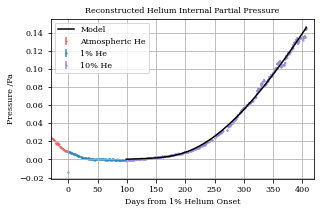

In [123]:
fig1 = plt.figure(figsize=figsize, facecolor='w')
plt.errorbar(x_0, y_0-k, zorder=0, yerr=y_err_0, fmt="C0s", label="Atmospheric He", markersize=1)
plt.errorbar(x_1, y_1-k, zorder=0, yerr=y_err_1, fmt="C1s", label="1% He", markersize=1)
plt.errorbar(x_2, y_2-k, zorder=0, yerr=y_err_2, fmt="C2s", label="10% He", markersize=1)
plt.plot(x_model, y_model -k, 'k-', label='Model', zorder=10)

plt.ylabel("Pressure /Pa")
plt.title("Reconstructed Helium Internal Partial Pressure")
plt.xlim(-30, 420)
plt.legend(loc='upper left')
plt.xlabel("Days from 1% Helium Onset")

plt.tight_layout()

plt.savefig("/Users/williamquinn/Desktop/PMT_Project/pi_pk_vs_time.pdf")
#plt.close()

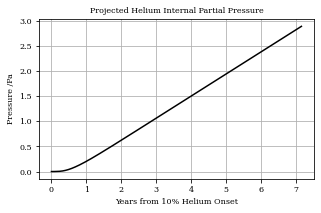

In [129]:
fig1 = plt.figure(figsize=figsize, facecolor='white')
x = []
y = []
x_i = 0
y_i = 0
while y_i <= 2.9:
    y_i = Model_0().func(np.array([x_i]), pars)[0]
    x.append(x_i)
    y.append(y_i)
    x_i += 1
x = np.array(x)
y = np.array(y)
plt.plot((x)/365, y -k, 'k-')
plt.ylabel("Pressure /Pa")
plt.xlabel("Years from 10% Helium Onset")
plt.title("Projected Helium Internal Partial Pressure")
#plt.xlim(0, x[-1])

plt.tight_layout()
plt.savefig("/Users/williamquinn/Desktop/PMT_Project/pred_pi.pdf")

In [140]:
x_i = 0
y_i = 0
while y_i <= 0.13:
    y_i = Model_var().func(np.array([x_i]), pars, p = 101325)[0]
    x_i += 1
print(x_i, x_i/365)

119 0.32602739726027397
